# Black-Scholes
El presente proyecto tiene como objetivo verificar los supuestos principales sobre los que se fundamenta el modelo de **Black-Scholes**, previo a la valuación de dos opciones europeas: una de compra (call) y una de venta (put). Para ambas opciones se considera un vencimiento de tres meses.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import anderson
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import norm

## **Datos**
Se utilizó una muestra de 504 precios de cierre diarios correspondientes al ETF SPDR Gold Shares (GLD) listado en la Bolsa Mexicana de Valores (BMV).  

Las observaciones abarcan un periodo de dos años, comprendido entre el 05/12/2023 y el 09/12/2025.  



In [14]:
#Los datos son obtenidos de un repositorio público en Git Hub
gold=pd.read_csv("https://raw.githubusercontent.com/denilson-sl/Archivos/refs/heads/main/SPDR%20Gold%20Shares.csv")

In [15]:
#Preservamos únicamente las fechas y los precios de cierre del DataFrame original
gold.columns=['Fecha','Cierre']
gold['Fecha']=pd.to_datetime(gold['Fecha'])

#Cálculo de rendimientos simples y logarítmicos
gold['Rendimiento'] = gold['Cierre'].pct_change()
gold['R_log'] = np.log(gold['Cierre'] / gold['Cierre'].shift(1))
gold.drop(0,axis=0,inplace=True)
gold.reset_index(drop=True,inplace=True)
gold.head(5)


,Fecha,Cierre,Rendimiento,R_log
0,2023-12-05,3251.000000,-0.009219,-0.009262
1,2023-12-06,3241.159912,-0.003027,-0.003031
2,2023-12-07,3284.000000,0.013218,0.013131
3,2023-12-08,3234.169922,-0.015174,-0.015290
4,2023-12-11,3189.810059,-0.013716,-0.013811


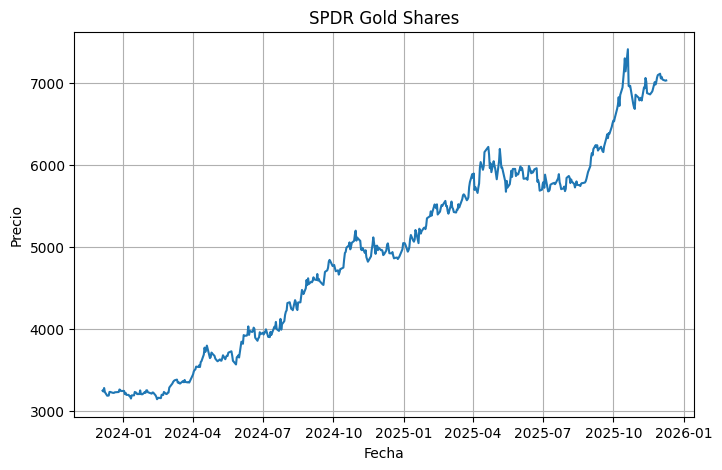

In [16]:
#Gráfica de los precios del activo subyacente
plt.figure(figsize=(8,5))
plt.plot(gold['Fecha'],gold['Cierre'])
plt.title('SPDR Gold Shares')
plt.ylabel('Precio')
plt.xlabel('Fecha')
plt.grid(True)
plt.show()

## **Comprobación de supuestos**
El modelo de Black-Scholes se fundamenta en los siguientes supuestos:


1.   El mercado es completo.
2.   No existen oportunidades de arbitraje.
3.   Probabilidad neutra al riesgo.
4.   No hay costos de transacción.
5.   Se pueden realizar ventas y compras en cualquier momento.
6.   El subyacente no paga dividendos (en la versión clásica del modelo).
7.   El precio del activo sigue un movimiento geométrico browniano (GBM).

Para verificar que el GBM es representativo del comportamiento del activo, es necesario comprobar que:



*   Los rendimientos logarítmicos sean independientes y sigan una distribución normal.
*   La varianza sea constante (homocedasticidad).


### Normalidad de los rendimientos logarítmicos

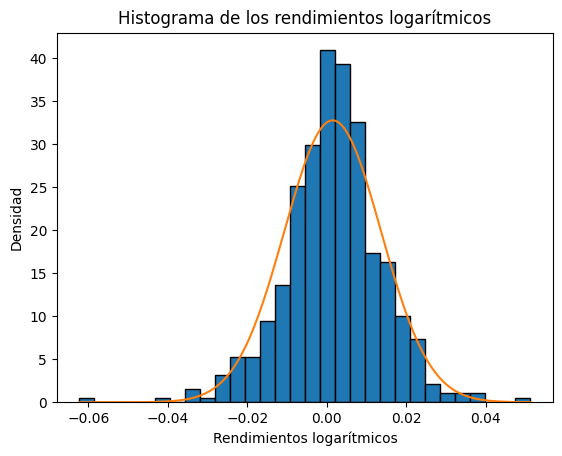

In [17]:
#Superposición del histograma de los rendimientos logarítmicos versus la distribución teórica normal

#Estimación de los parámetros de la distribución normal
mu = gold['R_log'].mean()
sigma = gold['R_log'].std()

# Rango de la gráfica
rango = np.linspace(gold['R_log'].min(), gold['R_log'].max(), 200)
pdf_normal = norm.pdf(rango,loc=mu, scale=sigma)

#Histograma
plt.hist(gold['R_log'],density=True,bins=30,edgecolor='Black')
plt.plot(rango, pdf_normal)
plt.title('Histograma de los rendimientos logarítmicos')
plt.xlabel('Rendimientos logarítmicos')
plt.ylabel('Densidad')
plt.show()

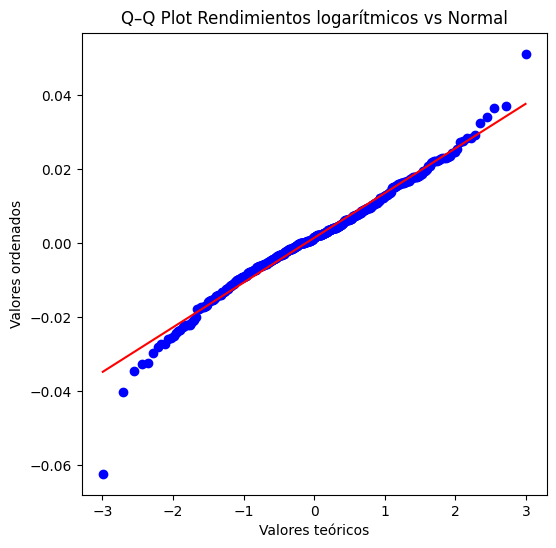

In [18]:
#Q-Q plot
plt.figure(figsize=(6,6))
stats.probplot(gold['R_log'], dist="norm", plot=plt)
plt.title("Q–Q Plot Rendimientos logarítmicos vs Normal")
plt.xlabel("Valores teóricos")
plt.ylabel("Valores ordenados")
plt.show()


In [19]:
#Prueba de bondad de ajuste
result = anderson(gold['R_log'], dist='norm')
print("Estadístico A²:", result.statistic)
print("Valores críticos:", result.critical_values)
print("Niveles de significancia (%):", result.significance_level)

Estadístico A²: 1.8755801383495623
Valores críticos: [0.572 0.651 0.781 0.911 1.084]
Niveles de significancia (%): [15.  10.   5.   2.5  1. ]


Se concluye que **los rendimientos logarítmicos no siguen una distribución normal**. Poseen colas pesadas que no son tomadas en cuenta por el modelo y, por ende, Black-Scholes termina subestimando la posibilidad de movimientos bruscos, lo que implica la **subvaluación de las opciones muy fuera del dinero (OTM)**, ya que asume que la probabilidad de cruzar el strike es más baja de lo que realmente ocurre en la práctica.

### Autocorrelación de los rendimientos logarítmicos

<Figure size 800x400 with 0 Axes>

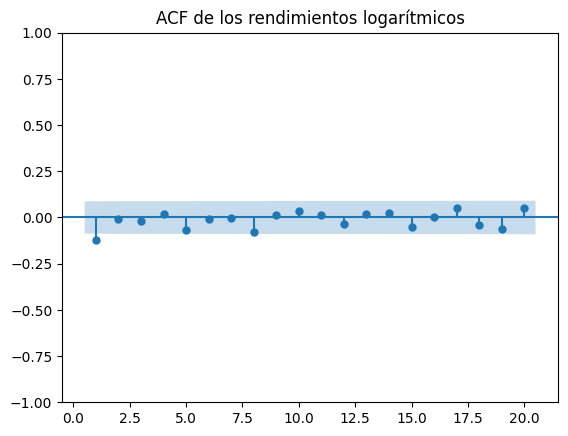

In [20]:
#ACF
plt.figure(figsize=(8,4))
plot_acf(gold['R_log'], lags=20, zero=False)
plt.title("ACF de los rendimientos logarítmicos")
plt.show()


### Varianza constante

<Figure size 800x400 with 0 Axes>

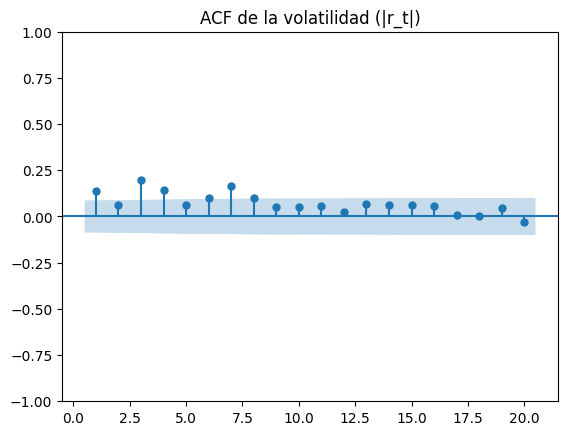

In [21]:
#ACF de la volatilidad (|r_t|)
abs_r = gold['R_log'].abs()

plt.figure(figsize=(8,4))
plot_acf(abs_r, lags=20, zero=False)
plt.title("ACF de la volatilidad (|r_t|)")
plt.show()


<Figure size 800x400 with 0 Axes>

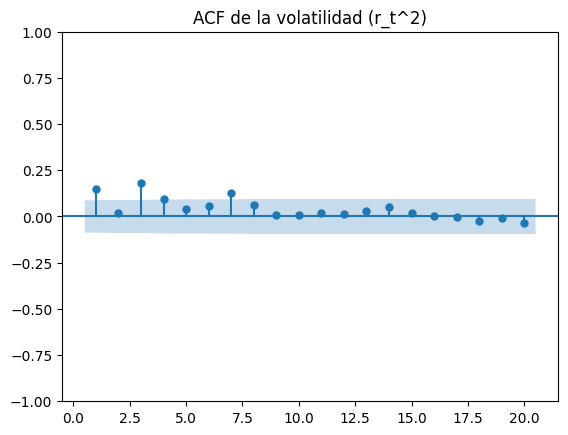

In [22]:
#ACF de la volatilidad (r_t^2)
r2 = gold['R_log']**2

plt.figure(figsize=(8,4))
plot_acf(r2, lags=20, zero=False)
plt.title("ACF de la volatilidad (r_t^2)")
plt.show()


In [23]:
# Prueba ARCH LM
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(gold['R_log'])

print("LM statistic:", lm_stat)
print("LM p-value:", lm_pvalue)
print("F-statistic:", f_stat)
print("F p-value:", f_pvalue)

LM statistic: 34.304520277269376
LM p-value: 0.0001639917776935803
F-statistic: 3.6043607180812165
F p-value: 0.00012254729929013998


Media primer periodo: 0.0015307368969143652
Media segundo periodo: 0.0020794108565222224
Media tercer periodo: 0.0009190341025623523
Desviación primer periodo: 1.13%
Desviación segundo periodo: 1.20%
Desviación tercer periodo: 1.32%


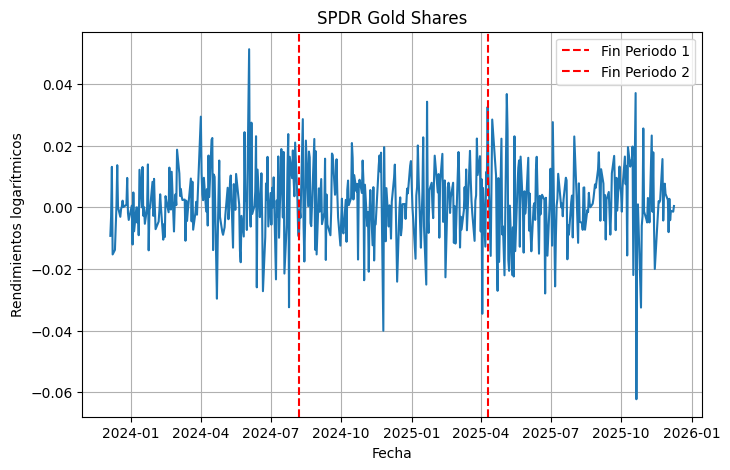

In [24]:
#Rolling windows
#Se particiona la muestra en tres partes iguales
k=np.floor((gold['R_log'].count()/3))
k=int(k)
mu1=gold['R_log'][0:k+1].mean()
mu2=gold['R_log'][k+1:2*k+2].mean()
mu3=gold['R_log'][2*k+2:].mean()
sigma1=gold['R_log'][0:k+1].std()*100
sigma2=gold['R_log'][k+1:2*k+2].std()*100
sigma3=gold['R_log'][2*k+2:].std()*100
print(f"Media primer periodo: {mu1}")
print(f"Media segundo periodo: {mu2}")
print(f"Media tercer periodo: {mu3}")
print(f"Desviación primer periodo: {sigma1:.2f}%")
print(f"Desviación segundo periodo: {sigma2:.2f}%")
print(f"Desviación tercer periodo: {sigma3:.2f}%")

plt.figure(figsize=(8,5))
plt.plot(gold['Fecha'],gold['R_log'])
plt.title('SPDR Gold Shares')
plt.ylabel('Rendimientos logarítmicos')
plt.xlabel('Fecha')

# Líneas verticales de las particiones
linea_1 = gold['Fecha'].iloc[k]
linea_2 = gold['Fecha'].iloc[2*k+1]

plt.axvline(x=linea_1, color='red', linestyle='--', label='Fin Periodo 1')
plt.axvline(x=linea_2, color='red', linestyle='--', label='Fin Periodo 2')

plt.grid(True)
plt.legend()
plt.show()

Los datos muestran evidencia estadística de heterocedasticidad condicional, por lo que la varianza no es constante, sino que depende de la volatilidad pasada. En presencia de clusters de volatilidad, l**os precios obtenidos por el modelo no reflejan los precios reales**, ya que la volatilidad implícita no necesariamente va a coincidir con la volatilidad asumida.



## Valuación

Sea:
- $S_0$: precio actual del activo subyacente  
- $K$: precio de ejercicio (strike)  
- $r$: tasa libre de riesgo (continua)  
- $\sigma$: volatilidad anualizada del subyacente  
- $T$: tiempo hasta el vencimiento (en años)  
- $N(\cdot)$: función de distribución de la normal estándar  

Definimos:

$d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)T}{\sigma \sqrt{T}}$

$d_2 = d_1 - \sigma \sqrt{T}$

### Valor de la opción Call europea
$C = S_0 \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)$

### Valor de la opción Put europea
$P = K \cdot e^{-rT} \cdot N(-d_2) - S_0 \cdot N(-d_1)$

### Paridad Put–Call
$C - P = S_0 - K e^{-rT}$

In [25]:
def bs_call(S, K, r, sigma, T):
    if T==0:
        return max(S-K,0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call

def bs_put(S, K, r, sigma, T):
    if T==0:
        return max(K-S,0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put

In [26]:
# ----- Parámetros -----
S=gold['Cierre'].iloc[-1]
k=7000
r = 0.072                    # tasa libre de riesgo anual: Cetes a 91 días.
sigma=gold['R_log'][-252:].std()*np.sqrt(252)
T = 90 / 365                 # Tres meses medidos en años

print(f"Call = ${bs_call(S, k, r, sigma, T):.6f}")
print(f"Put  = ${bs_put(S, k, r, sigma, T):.6f}")
print("Paridad Put-Call:\n")
print(f"C-P = ${bs_call(S, k, r, sigma, T)-bs_put(S, k, r, sigma, T):.6f}")
print(f"Paridad teórica: ${S - k*np.exp(-r*T):.6f}")


Call = $365.163137
Put  = $206.976044
Paridad Put-Call:

C-P = $158.187093
Paridad teórica: $158.187093


## Recomendación
El análisis empírico realizado sobre los rendimientos logarítmicos del subyacente evidencia incumplimientos relevantes de los supuestos fundamentales del modelo de GBM:

- Los rendimientos **no siguen una distribución normal**, presentando colas pesadas.
- Existe **heterocedasticidad condicional**.
- La volatilidad **no es constante en el tiempo** y muestra clustering.

La recomendación es **migrar desde un modelo de volatilidad constante hacia un modelo de volatilidad condicional**, manteniendo Black–Scholes únicamente como referencia y no como modelo final.

## Acciones recomendadas

#### 1. Se recomienda estimar un modelo **GARCH(1,1)** como punto de partida, dado que es capaz de capturar adecuadamente el clustering de volatilidad.

#### 2. Debido a las colas pesadas en los rendimientos logarítmicos, se recomienda especificar innovaciones con las distribuciones de **t-Student** o **GED**.

Posteriormente, validar que los residuos estandarizados:
- no presenten autocorrelación,
- no tengan efectos ARCH,
- muestren mejor ajuste a la distribución teórica a través de Q-Q plots y pruebas de bondad de ajuste.

#### 3. Se puede explorar la valuación del derivado mediante simulación Monte Carlo utilizando trayectorias generadas por el modelo GARCH.


### Conclusión
El modelo Black–Scholes es útil como punto de referencia, pero **no refleja en su totalidad la dinámica de los datos observados**. La evidencia de heterocedasticidad condicional y de distribuciones no normales en los rendimientos sugiere la exploración de modelos ARCH/GARCH o de volatilidad estocástica, que permitan una representación más realista del comportamiento del mercado.
